In [1]:
import theano; 
theano.config.blas.ldflags=""  #-LC:\openblas\bin -lopenblas"
print (theano.config.blas.ldflags)
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Reshape,Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
#import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
#from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
from skimage.filters import roberts, sobel, scharr, prewitt


#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# set the necessary directories
data_dir = 'C:/data/kag/d/train/train/'#"../input/train/"
mask_dir = 'C:/data/kag/d/train_masks/train_masks/' #"../input/train_masks/"
#all_images = os.listdir(data_dir)

Using Theano backend.


In [3]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

#!pip install --upgrade scikit-image
import skimage
print ('skimage.__version__',skimage.__version__)

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift , watershed,find_boundaries
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float,img_as_ubyte
from skimage import filters

name=  '8d1a6723c458_01'# '8d1a6723c458_08' 

img_s= load_img(data_dir+ name+'.jpg')
msk_s= load_img(mask_dir+name + '_mask.gif')


from skimage import data
img = img_as_float(img_s)
print (img.shape)
#img = img[::,::,2]

#edges = filters.sobel(img)
#plt.imshow(img_s)
#plt.imshow(msk_s, alpha=0.5)
#plt.imshow(edges)


skimage.__version__ 0.13.0
(1280L, 1918L, 3L)


In [4]:
from skimage.color import rgb2gray

def get_edges(msk_s):
    msk = img_as_float(msk_s)  #uint8, mean=44
    #msk = data.camera() #uint8
    #print (msk.shape,msk.dtype,'max',msk.max())
    msk = rgb2gray(msk)*255
    #print (msk.shape,msk.dtype,'max',msk.max(),msk.mean())
    edges = filters.sobel(msk)
    edges=edges.astype(np.int8)
    edges= edges!=0
    #print (edges[500:520,190+379:190+390])
    #plt.imshow(edges)
    return edges

name= '8d1a6723c458_01'  # '8d1a6723c458_01'# '8d1a6723c458_08' 
img_s= load_img(data_dir+ name+'.jpg')
img = img_as_float(img_s)
msk_s= load_img(mask_dir+name + '_mask.gif')
sobol_edges= get_edges(msk_s)
print ('sum of sob   =',sobol_edges.sum())


# sobol creates a wide line of 2 pixels on edge, we only want the inner one
msk = img_as_float(msk_s)  #uint8, mean=44
msk = rgb2gray(msk)*255
sobol_inner_edges = np.logical_and(sobol_edges , msk!=0)
print ('sum of inner sob=',sobol_inner_edges.sum())

(sobol_inner_edges.sum()+0.0)/(msk>0).sum()
(msk>0).sum()*0.003

sum of sob   = 7608
sum of inner sob= 3808


1287.5550000000001

In [7]:
print ('Target: sum of inner sob=',sobol_inner_edges.sum())


for scale in (8,10,12):
    for sigma in (0.4,0.45,0.50):
        for min_size in (30,):
            for mode in ['inner']: #['inner']:,'outer','thick']::
                segments_fz = felzenszwalb(img, scale=scale, sigma=sigma, min_size=min_size) #4s  scale=100, sigma=0.5, min_size=50
                segments_slic = slic(img, n_segments=1000)# compactness=10, sigma=1)  #??
                fz = find_boundaries(segments_fz, mode=mode)
                sl = find_boundaries(segments_slic, mode=mode)
                print (mode,'sum of sob+fz =',np.logical_and(fz,sobol_inner_edges).sum(),scale,sigma,min_size) #
                print (mode,'sum of sob+sl =',np.logical_and(sl,sobol_inner_edges).sum(),scale,sigma,min_size) #

#2272 30 0.5 45 thick
#2328 25 0.55 43 thick
#2739 15 0.4 20 thick

#2802 15 0.45 20 thick
#3407 12 0.4 5 thick

######### different image
#3393 12 0.4  1 (1 is the important)
#3407 12 0.45 1 thick

Target: sum of inner sob= 3808
inner sum of sob+fz = 2428 8 0.4 30
inner sum of sob+sl = 840 8 0.4 30
inner sum of sob+fz = 2480 8 0.45 30
inner sum of sob+sl = 840 8 0.45 30
inner sum of sob+fz = 2465 8 0.5 30
inner sum of sob+sl = 840 8 0.5 30
inner sum of sob+fz = 2461 10 0.4 30
inner sum of sob+sl = 840 10 0.4 30
inner sum of sob+fz = 2436 10 0.45 30
inner sum of sob+sl = 840 10 0.45 30
inner sum of sob+fz = 2495 10 0.5 30
inner sum of sob+sl = 840 10 0.5 30
inner sum of sob+fz = 2452 12 0.4 30
inner sum of sob+sl = 840 12 0.4 30
inner sum of sob+fz = 2493 12 0.45 30
inner sum of sob+sl = 840 12 0.45 30
inner sum of sob+fz = 2514 12 0.5 30
inner sum of sob+sl = 840 12 0.5 30


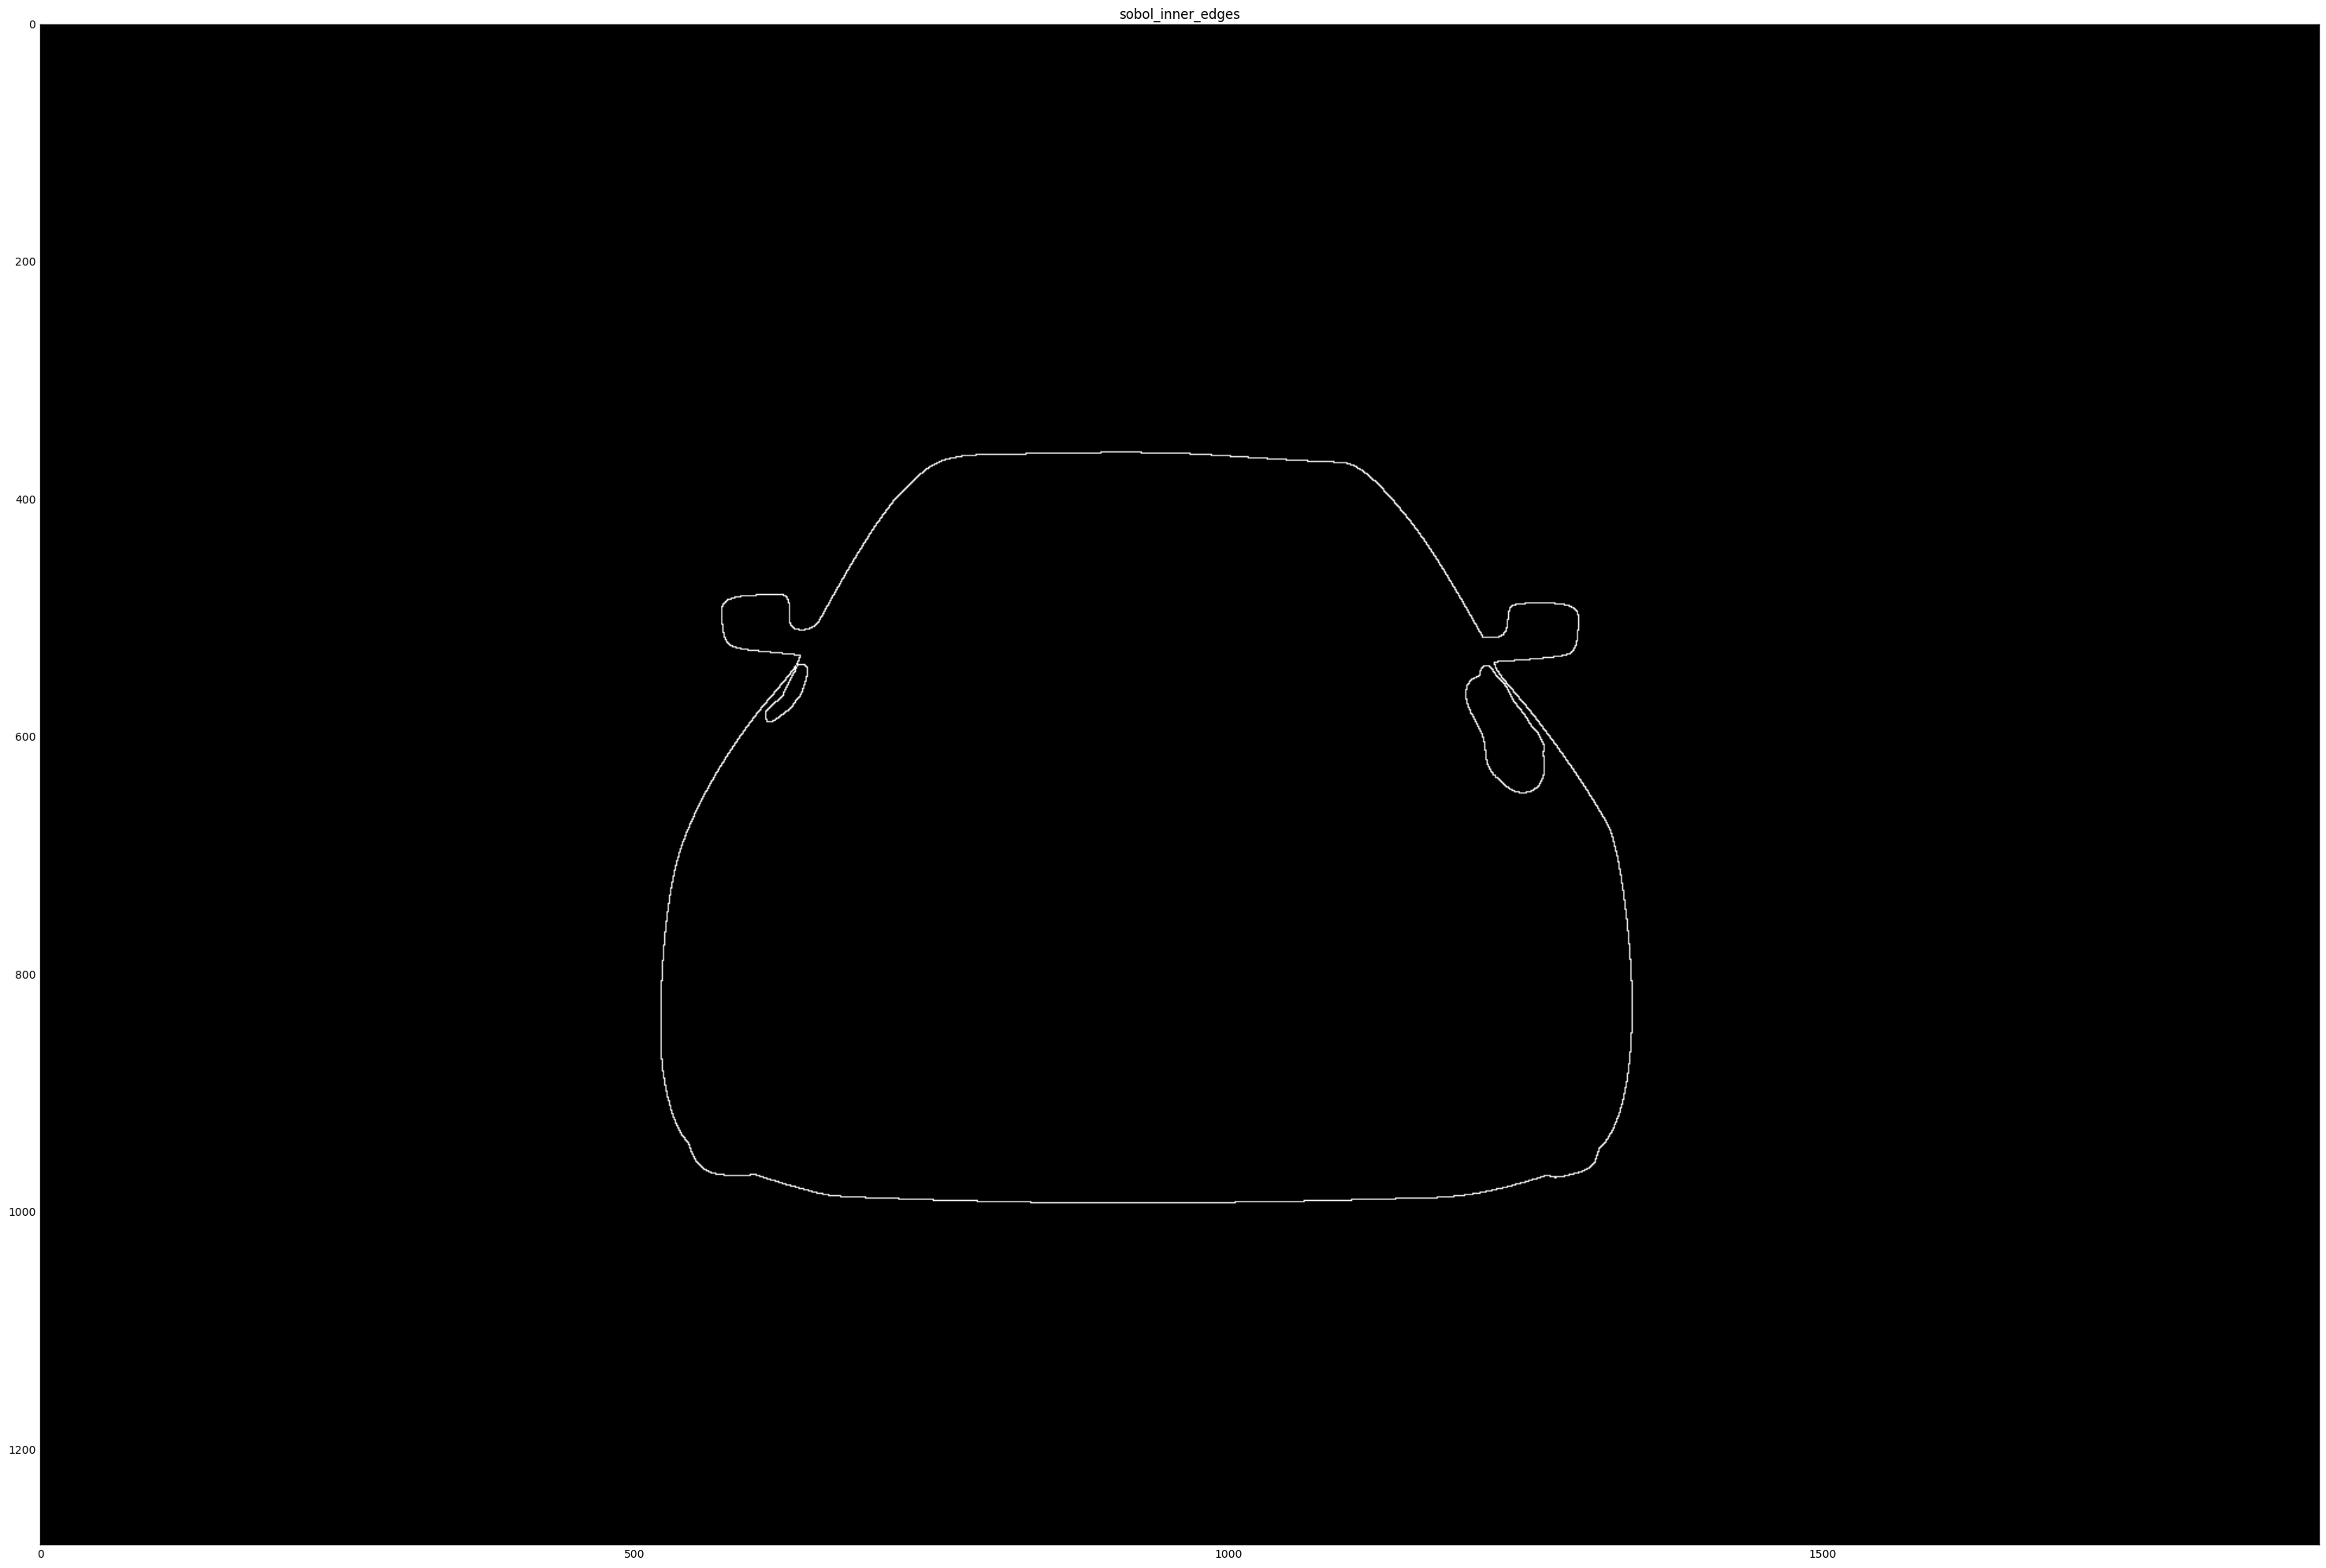

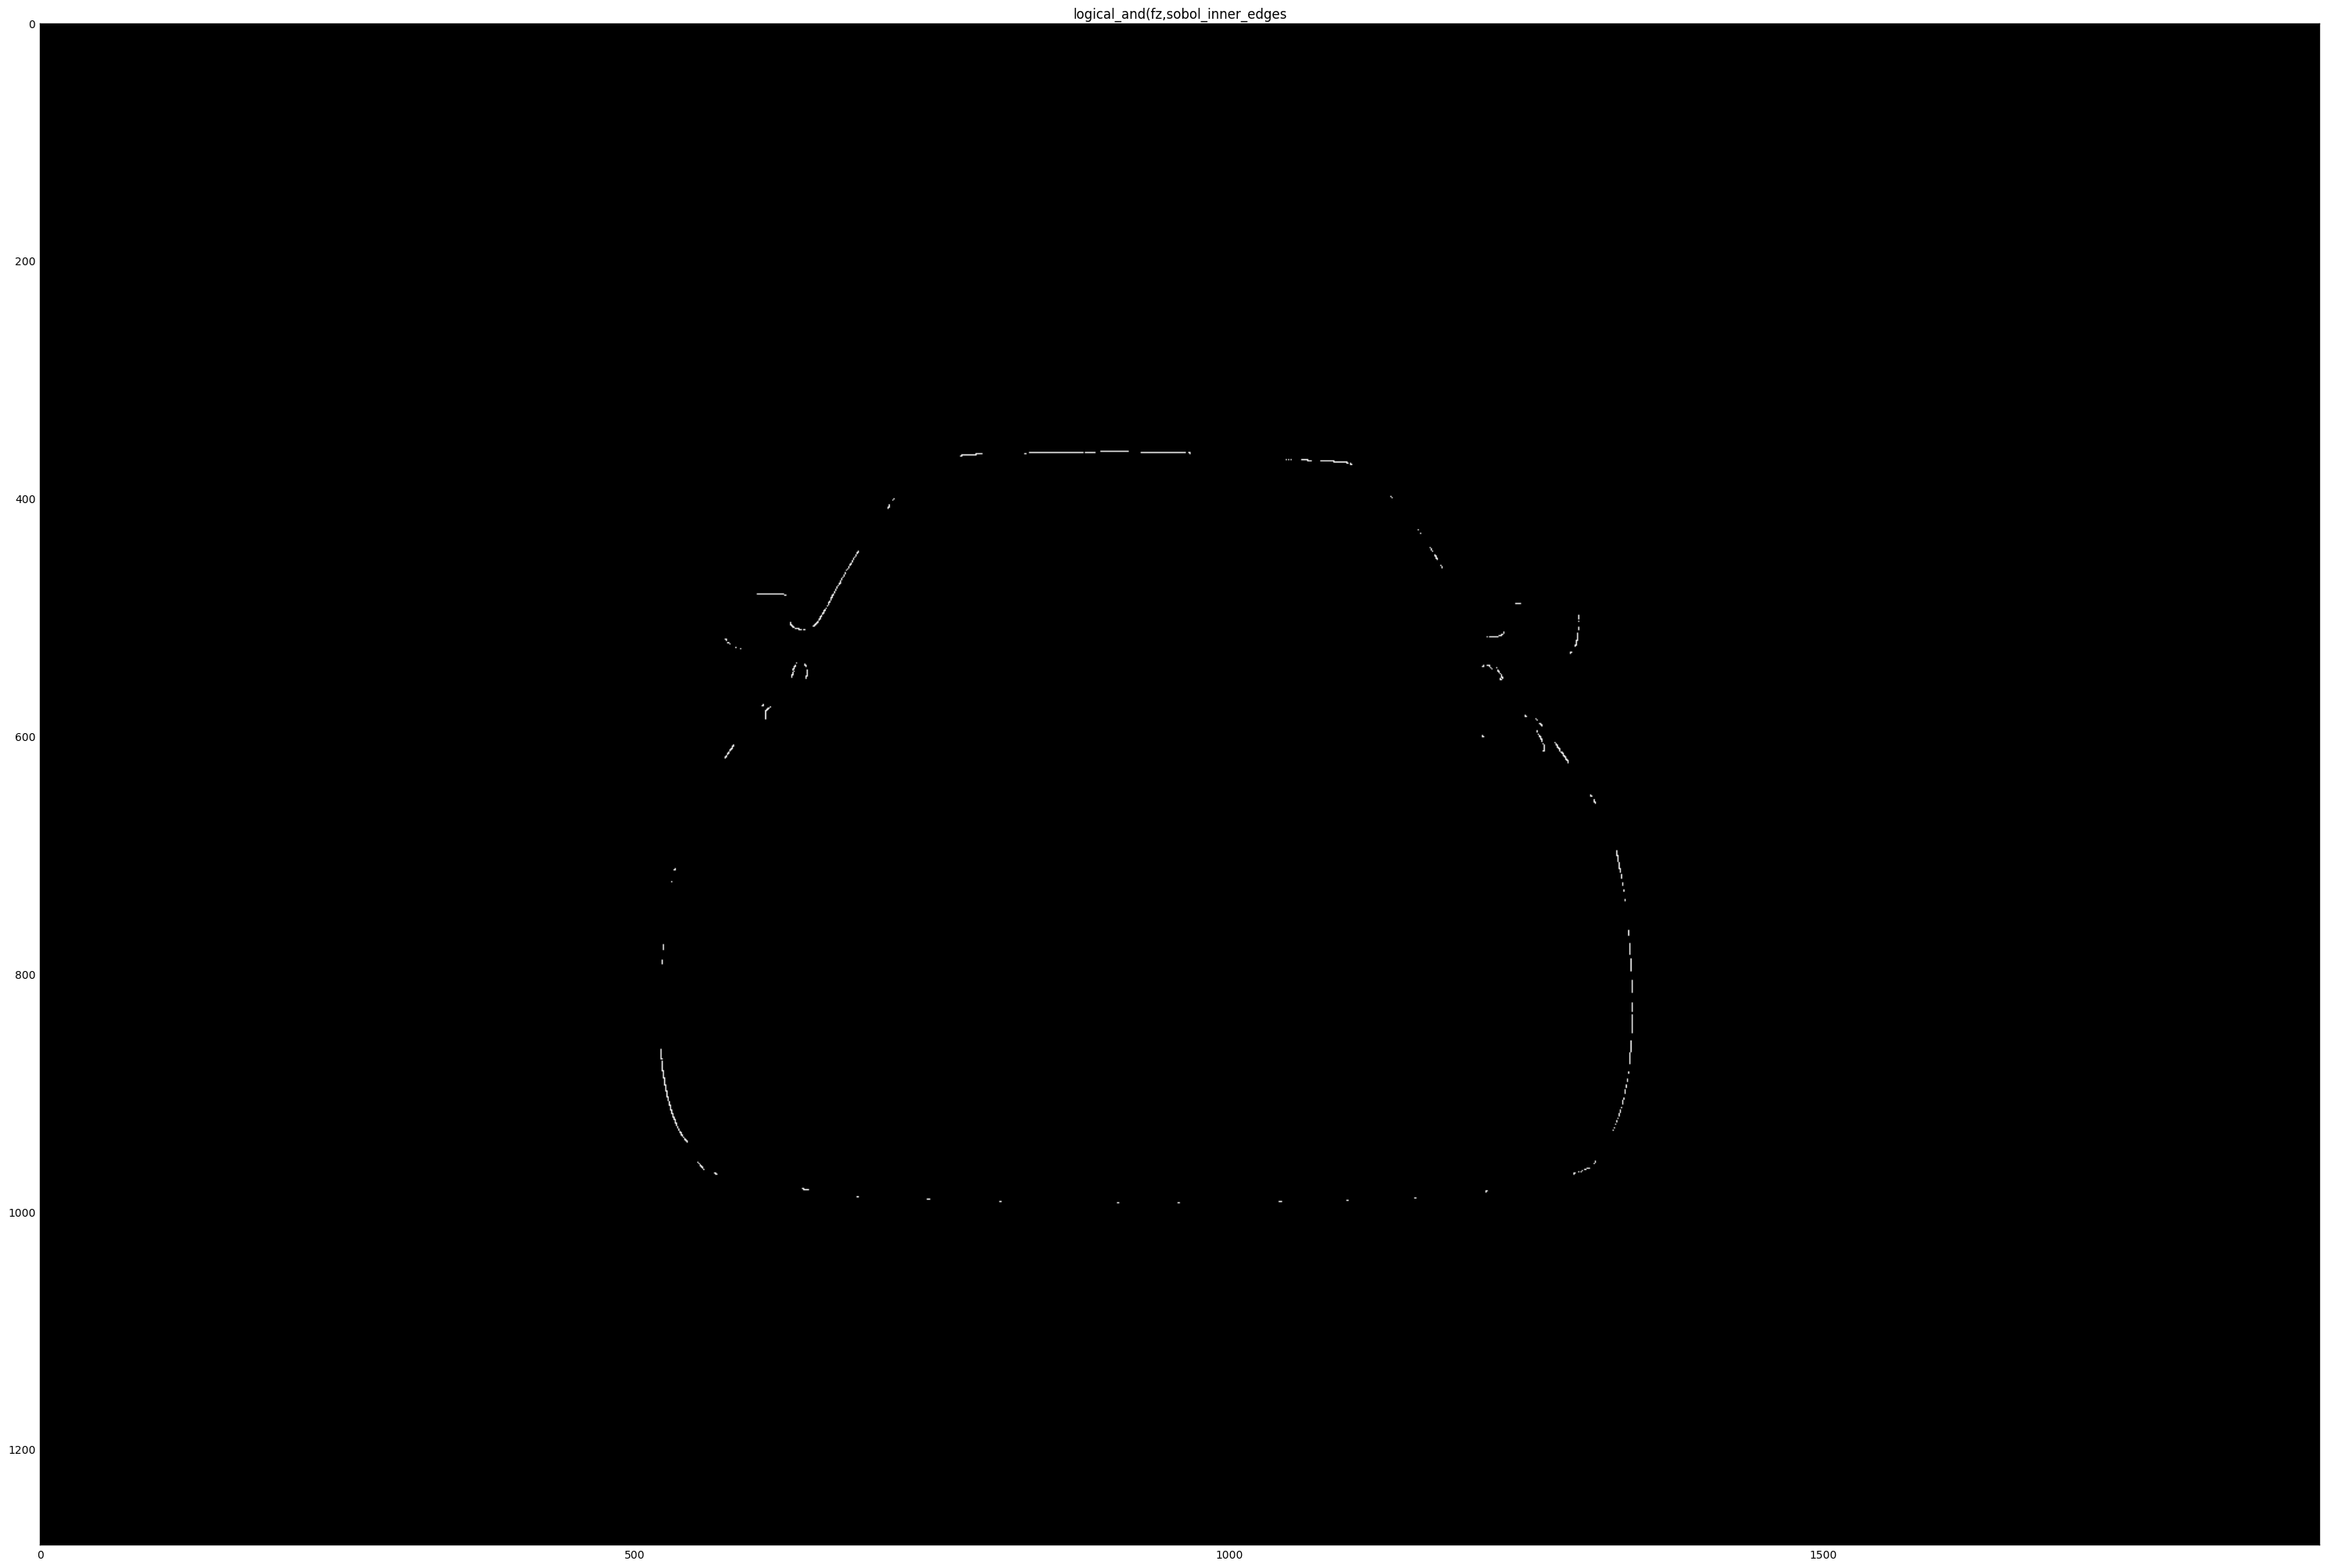

In [9]:
fig, ax = plt.subplots(figsize=(38, 20))
ax.imshow(sobol_inner_edges,cmap='gray')
plt.title('sobol_inner_edges')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(38, 20))
ax.imshow(np.logical_and(sl,sobol_inner_edges),cmap='gray')
plt.tight_layout()
plt.title('logical_and(fz,sobol_inner_edges')
plt.show()

(320L, 480L, 3L)
Wall time: 279 ms
Wall time: 8.59 s
Wall time: 17.5 s
Wall time: 11 ms
Wall time: 129 ms
Felzenszwalb number of segments: 1576
SLIC number of segments: 976
Quickshift number of segments: 639


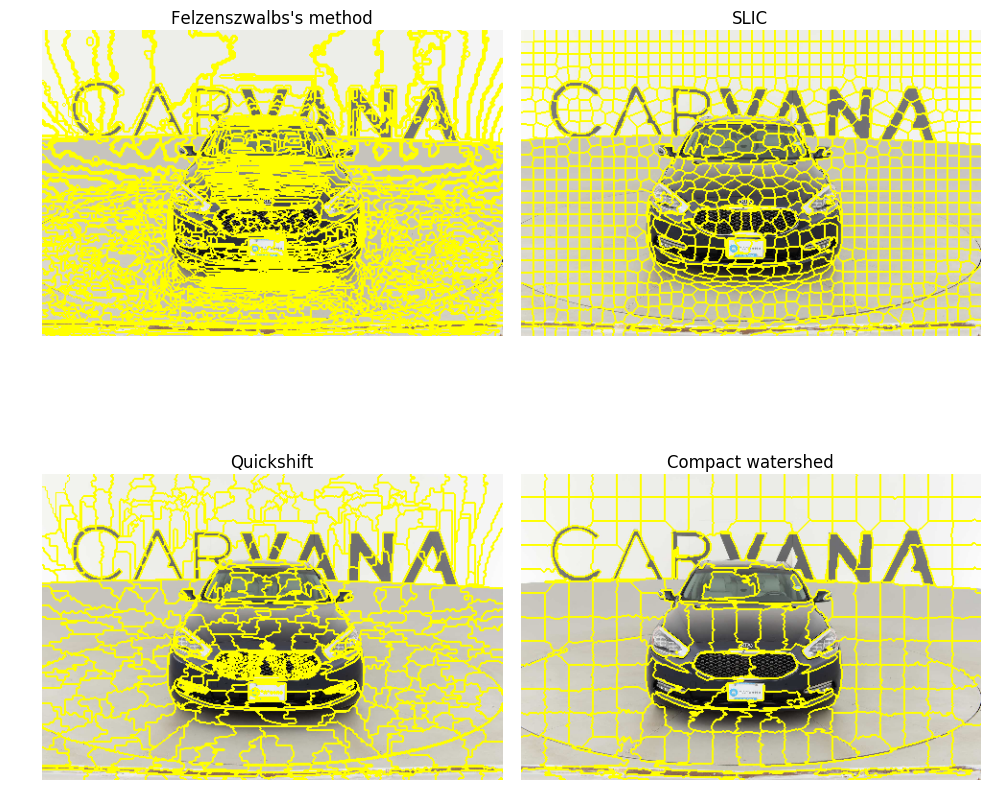

In [10]:

#img = img_as_float(astronaut()[::, ::])
img = img_as_float(img_s)
img = img[::4,::4]
print (img.shape)


#(320L, 480L, 3L)  ~20ms

%time segments_fz = felzenszwalb(img, scale=12, sigma=0.45, min_size=20) #200ms

%time segments_slic = slic(img, n_segments=1000, compactness=10, sigma=1)  #6.4 250 np components was before
%time segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5) #13.8s
%time gradient = sobel(rgb2gray(img)) #10ms
%time segments_watershed = watershed(gradient, markers=250, compactness=0.001) #89ms

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})
mode='inner'
ax[0, 0].imshow(mark_boundaries(img, segments_fz, mode=mode))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic, mode=mode))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick, mode=mode))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed, mode=mode))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()